In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **RNN의 문제점**

RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어렵다. 그 원인은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다.

## **기울기 소실 또는 기울기 폭발**

현재의 단순한 RNN 계층에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나(기울기 소실) 혹은 커질 수 있으며(기울기 폭발), 대부분 둘 중 하나의 운명을 걷게 된다. 따라서 학습 과정에서 가중치 매개변수가 전혀 갱신되지 않게 된다.

## **기울기 소실과 기울기 폭발의 원인**

첫째로 $tanh(x)$함수의 미분 때문에 역전파에서 기울기가 tanh 노드를 지날 때마다 값은 계속 작아진다. 때문에 tanh 함수를 $T$번 통과하면 기울기도 $T$번 반복해서 작아지게 된다.

둘째로는 MatMul(행렬 곱) 노드 차례에서 문제가 발생한다. 행렬 곱에만 주목했을 때의 역전파 기울기 계산에서 행렬 곱셈에서는 매번 똑같은 가중치인 $W_h$만 사용되게 되는데, 다음 코드로 기울기의 크기 변화를 관찰해보자.

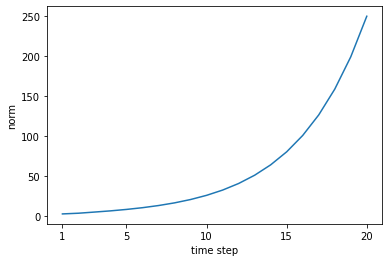

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 2       # 미니배치 크기
H = 3       # 은닉 상태 벡터의 차원 수
T = 20      # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)       # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

그래프에서 보듯 기울기의 크기는 시간에 비례해 지수적으로 증가한다. 이것이 바로 **기울기 폭발(exploding gradients)**이다. 이러한 기울기 폭발이 일어나면 결국 오버플로를 일으켜 NaN 같은 값을 발생시킨다. 따라서 신경망 학습을 제대로 수행할 수 없는 것이다.

다음은 Wh의 초깃값을 변경한 후 두번째 실험을 해보자.

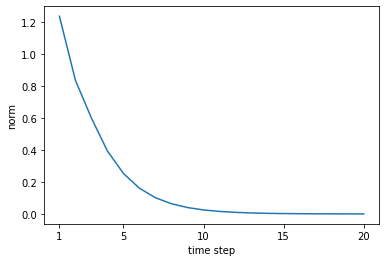

In [3]:
dh = np.ones((N, H))
np.random.seed(3)       # 재현할 수 있도록 난수의 시드 고정
# Wh = np.random.randn(H, H)        # 변경 전
Wh = np.random.randn(H, H) * 0.5    # 변경 후

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

그림에서 알 수 있듯이, 이번에는 기울기가 지수적으로 감소한다. 이것이 **기울기 소실(vanishing gradients)**이다. 기울기 소실이 일어나면 기울기가 매우 빠르게 작아지는데, 일정 수준 이하로 작아지면 가중치 매개변수가 더 이상 갱신되지 않으므로, 장기 의존 관계를 학습할 수 없게 된다.

기울기에서 지수적인 변화가 일어난 이유는 행렬 Wh를 T번 반복해서 '곱'했기 떄문이다. 하지만 Wh는 스칼라가 아니므로 그리 간단한 결론을 내릴 순 없다. 정확하게 말하면 행렬 Wh의 특잇값의 값(더 정확하게는 여러 특잇값 중 최댓값)이 1보다 큰지 여부를 보면 기울기 크기가 어떻게 변할지 예측할 수 있다.

## **기울기 폭발 대책**

기울기 폭발의 대책으로는 전통적으로 **기울기 클리핑(gradients clipping)**이라는 기법이 있다. 기울기 클리핑은 매우 단순하며, 그 알고리즘은 다음과 같다.

$$ if $$
$$  ||\hat{g}|| >= threshold:$$
$$ \hat{g} = \frac{threshold}{||\hat{g}} \hat{g} $$

기울기의 L2 노름(수식에서는 $||\hat{g}||$)이 $threshold$(문턱값)을 초과하면 두 번째 줄의 수식과 같이 기울기를 수정한다. 이것이 기울기 클리핑이며 많은 경우에 잘 작동한다.

이제 기울기 클리핑을 파이썬으로 구현해보자.

In [4]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


# **기울기 소실과 LSTM**

RNN 학습에서는 기울기 소실도 큰 문제이다. 이 문제를 해결하려면 RNN 계층의 아키텍처를 근본부터 뜯어 고쳐야 하는데, 여기서 핵심주제인 '게이트가 추가된 RNN'이 등장한다. 게이트가 추가된 RNN으로는 많은 아키텍처(신경망 구성)가 제안되어 있으며, 그 대표격으로 LSTM과 GRU가 있다. 이번절에는 LSTM에 집중하여 구조를 살펴보면서 LSTM이 기울기 소실을 일으키기 어렵게 한다는 사실을 밝힌다.

## **LSTM의 인터페이스**

RNN고 달리 LSTM 계층의 인터페이스에는 $c$라는 경로가 있다. 이 $c$를 **기억 셀(memory cell)**(혹은 단순히 '셀')이라 하며, LSTM 전용의 기억 메커니즘이다.

기억 셀의 특징은 데이터를 자기 자신으로만(LSTM 계층 내에서만) 주고받는다는 것이다. 즉, LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력하지 않는다. 반면 LSTM의 은닉 상태 $h$는 RNN 계층과 마찬가지로 다른 계층으로 출력된다. 그림으로 차이를 확인해보자.

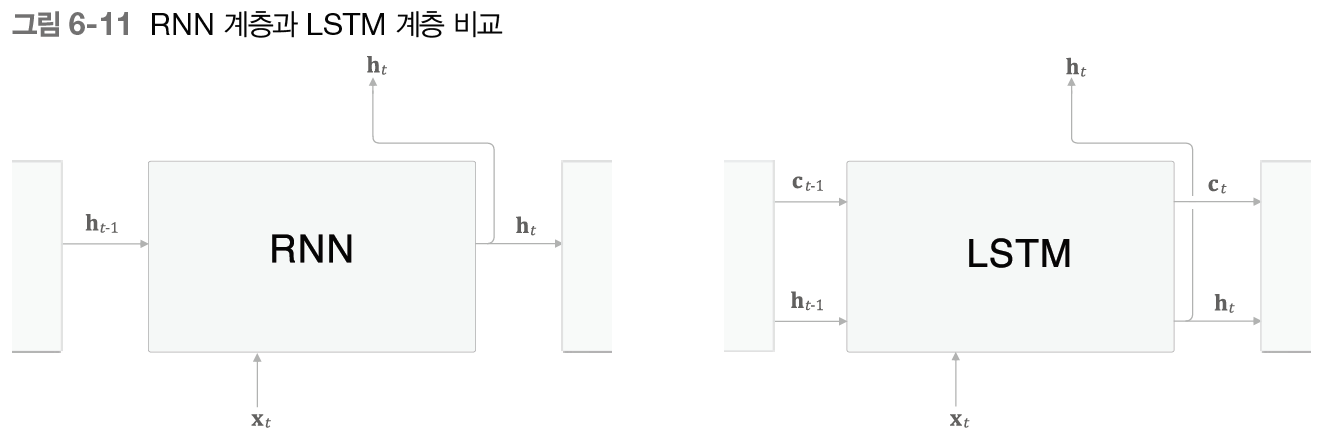

LSTM의 출력을 받는 쪽에서 보면 LSTM의 출력은 은닉 상태 벡터 $h$뿐이다. 기억 셀 $c$는 외부에서는 보이지 않는다. 따라서 그 존재 자체를 생각할 필요가 없다.

## **LSTM 계층 조립하기**

LSTM 계층에 대해서 그림으로 살펴보자.

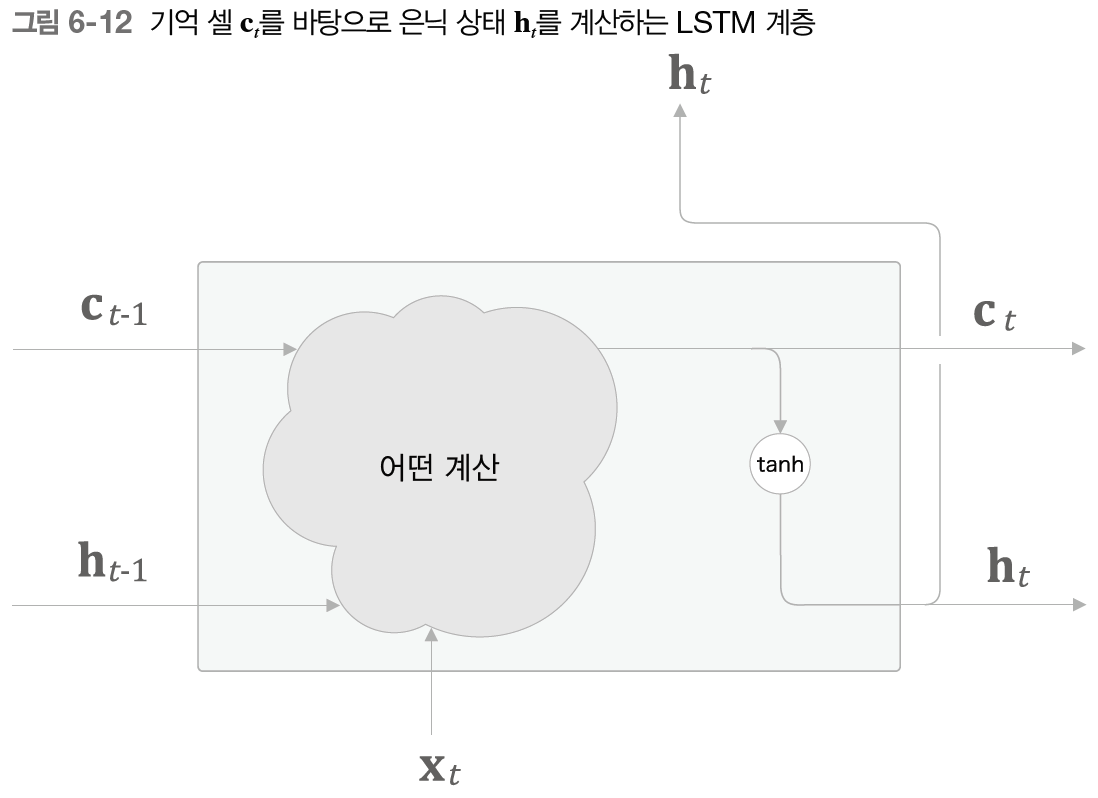

'게이트'라는 기능에 대해 간단하게 알아보자. 게이트란 우리말로 '문'을 의미하는 단어이다. 문은 열거나 닫을 수 있듯이, 게이트는 데이터의 흐름을 제어한다.

LSTM에서 사용하는 게이트는 '열기/닫기'뿐 아니라, 어느 정도 열지를 조절할 수 있다. 다시 말해 다음 단계로 흘려보낼 데이터의 양을 제어한다. 
'어느 정도'를 '열림 상태(openness)'라 부른다.

게이트의 열림 상태는 0.0~1.0 사이의 실수로 나타난다(1.0은 완전 개방, 시그모이드 함수를 사용하기 때문에 0-1 출력). 그리고 그 값이 다음으로 흐르는 데이터의 양을 결정한다. 여기서 중요한 것은 '게이트를 얼마나 열까'라는 것도 데이터로부터 (자동으로) 학습한다는 점이다.

## **output 게이트**

은닉 상태 $h_t$는 기억 셀 $c_t$에 단순히 tanh 함수를 적용했을 뿐이다. 이번 절에서는 $tanh(c_t)$에 게이트를 적용하는 걸 생각해보자. 즉, $tanh(c_t)$의 각 원소에 대해 '그것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정한다. 한편, 이 게이트는 다음 은닉 상태 $h_t$의 출력을 담당하는 게이트이므로 **output 게이트(출력 게이트)**라고 한다.

output 게이트의 열림 상태는 입력 $x_t$와 이전 상태 $h_{t-1}$로부터 구한다. 이때의 계산은 다음과 같은데, 여기서 사용하는 가중치 매개변수와 편항에는 output의 첫 글자인 $o$를 첨자로 추가한다. 시그모이드 함수는 $sigma()$로 표기한다.

$$ o = \sigma(x_t W_x^{(o)} + h_{t-1} W_h^{(o)} + b^{(o)}) $$

이것을 계산그래프로 표현하면 다음과 같다.


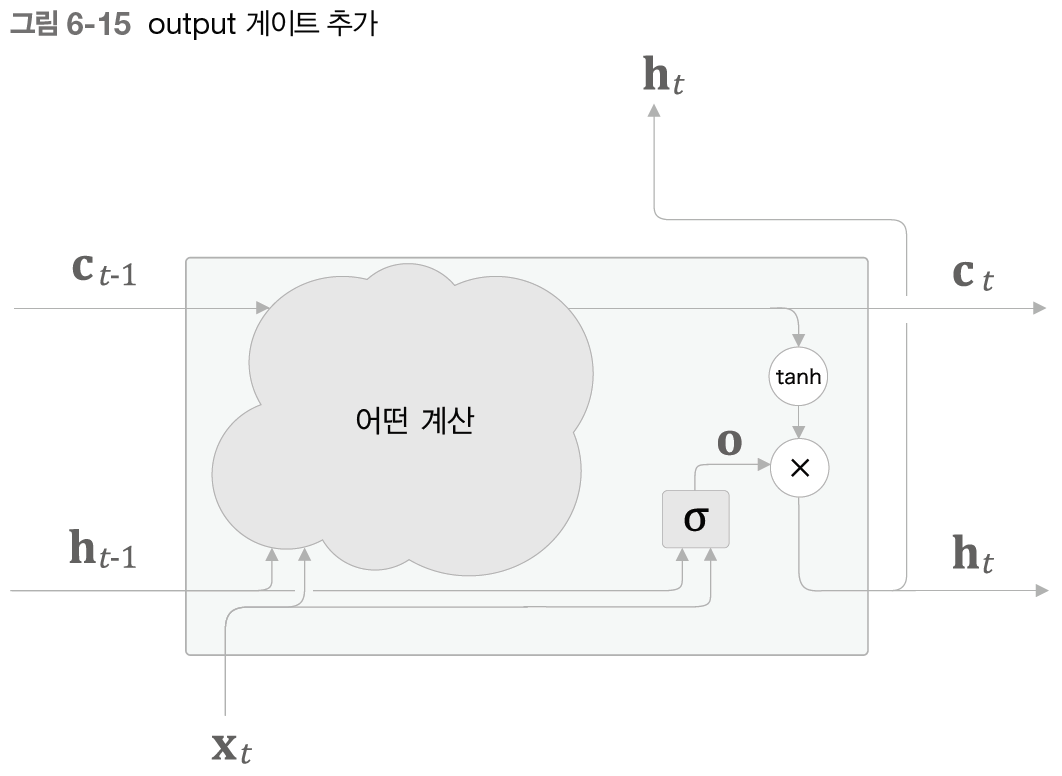

여기서 output 게이트의 계산 $\sigma$의 출력을 $o$라 하면 $h_t$는 $o$와 $tanh(c_t)$의 곱으로 계산된다. 여기서 말하는 '곱'이란 원소별 곱이며, 이것을 **아다마르 곱(Hadamard product)**라고 한다. 기호로는 다음과 같다.

$$ h_t = o \odot tanh(c_t) $$

## **forget 게이트**

우리가 다음에 해야 할 일은 기억 셀에 '무엇을 잊을까'를 명확하게 지시하는 것이다. 이런 일도 물론 게이트를 사용해 해결한다.

$c_{t-1}$의 기억 중에서 불필요한 기억을 잊게 해주는 게이트를 **forget 게이트(망각 게이트)**라 부른다. forget 게이트를 LSTM 계층에 추가하면 계산 그래프가 다음과 같다.

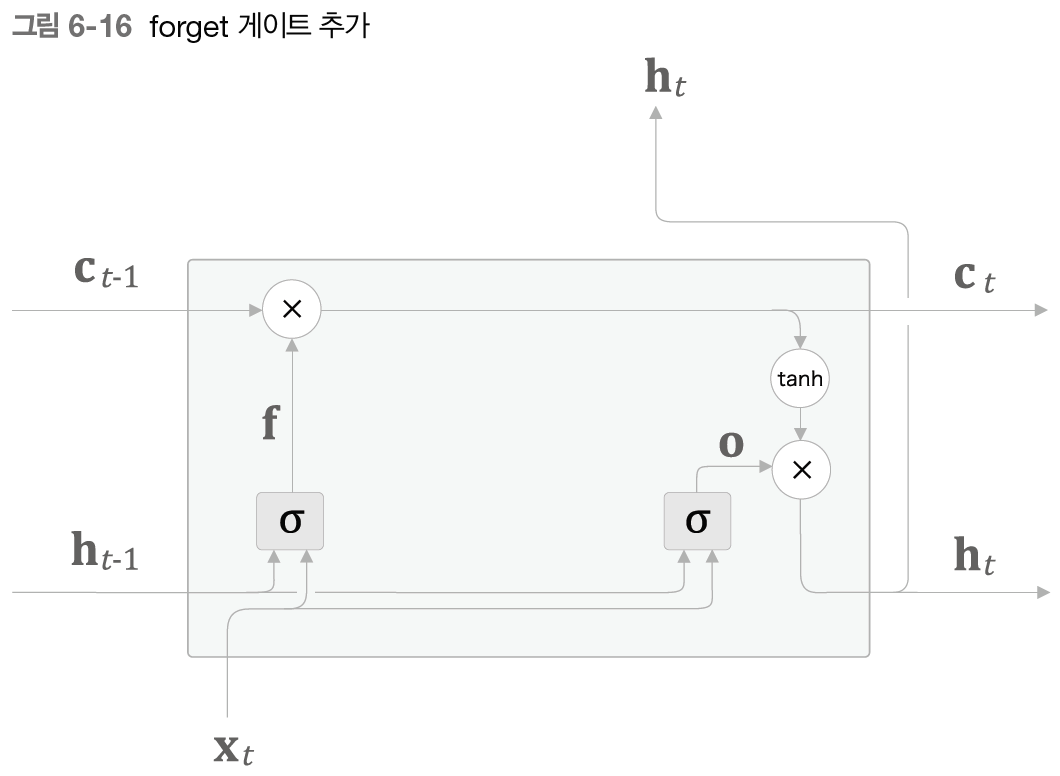

forget 게이트가 수행하는 일련의 계산을 $\sigma$ 노드로 표기하였는데, 다음 식의 계산을 수행한다.

$$ f = \sigma(x_t W_x^{(f)} + h_{t-1} W_h^{(f)} + b^{(f)}) $$

이 식을 실행하면 forget 게이트의 출력 $f$가 구해진다. 그리고 이 $f$와 이전 기억 셀인 $c_{t-1}$과의 원소별 곱, 즉 $c_t = f \odot c_{t-1}$을 계산하여 $c_t$를 구한다.

## **새로운 기억 셀**

forget 게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제되었다. 그런데 이 상태로는 기억 셀이 잊는 것밖에 하지 못한다. 따라서 새로 기억해야 할 정보를 기억셀에 추가해야 한다. 그러기 위해서 다음과 같이 tanh 노드를 추가한다.

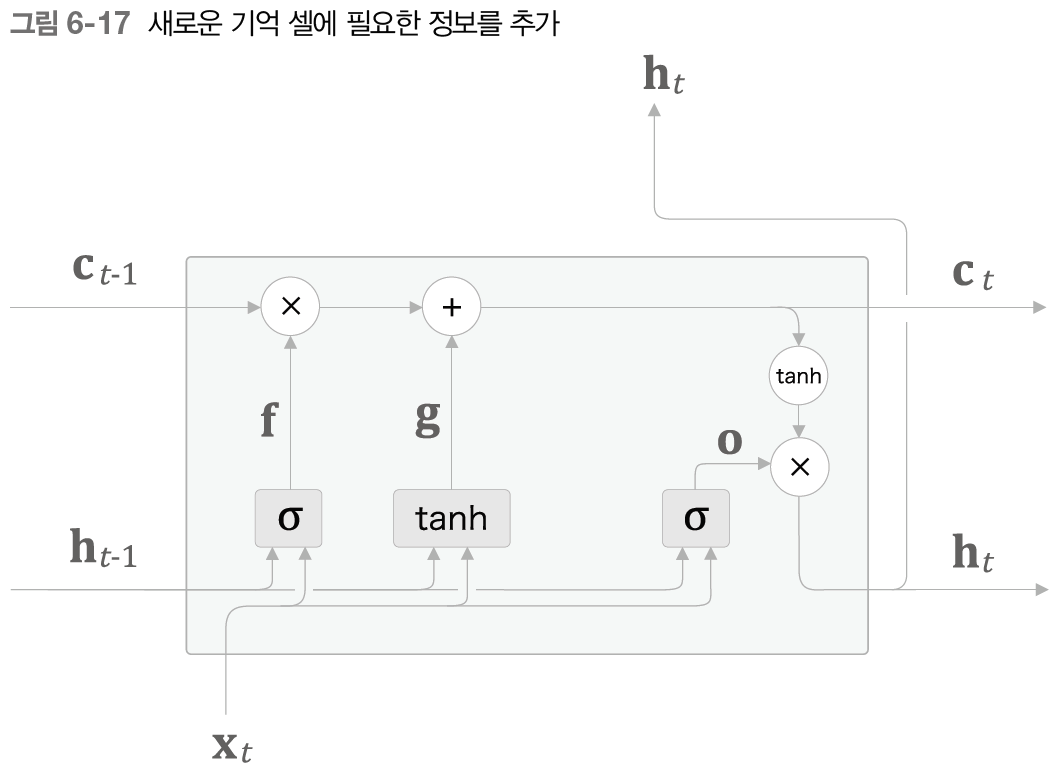

그림에서 보듯 tanh 노드가 계산한 결과가 이전 시각의 기억 셀 $c_{t-1}$에 더해진다. 기억 셀에 새로운 '정보'가 추가된 것이다. 이 tanh 노드는 '게이트'가 아니며, 새로운 '정보'를 기억 셀에 추가하는 것이 목적이다. 따라서 활성화 함수로는 시그모이드 함수가 아닌 tanh 함수가 사용된다. 이 tanh 노드에서 수행하는 계산은 다음과 같다.


$$ g = \tanh(x_t W_x^{(g)} + h_{t-1} W_h^{(g)} + b^{(g)}) $$

여기에서는 기억 셀에 추가하는 새로운 기억을 $g$로 표기했다. 이 $g$가 이전 시각의 기억 셀인 $c_{t-1}$에 더해짐으로써 새로운 기억이 생겨난다.

## **input 게이트**

마지막으로 윗 그림의 $g$에 게이트를 하나 추가할 예정이다. 새롭게 추가하는 게이트를 **input 게이트(입력 게이트)**라고 한다. input 게이트를 추가하면 계산 그래프가 다음과 같다.

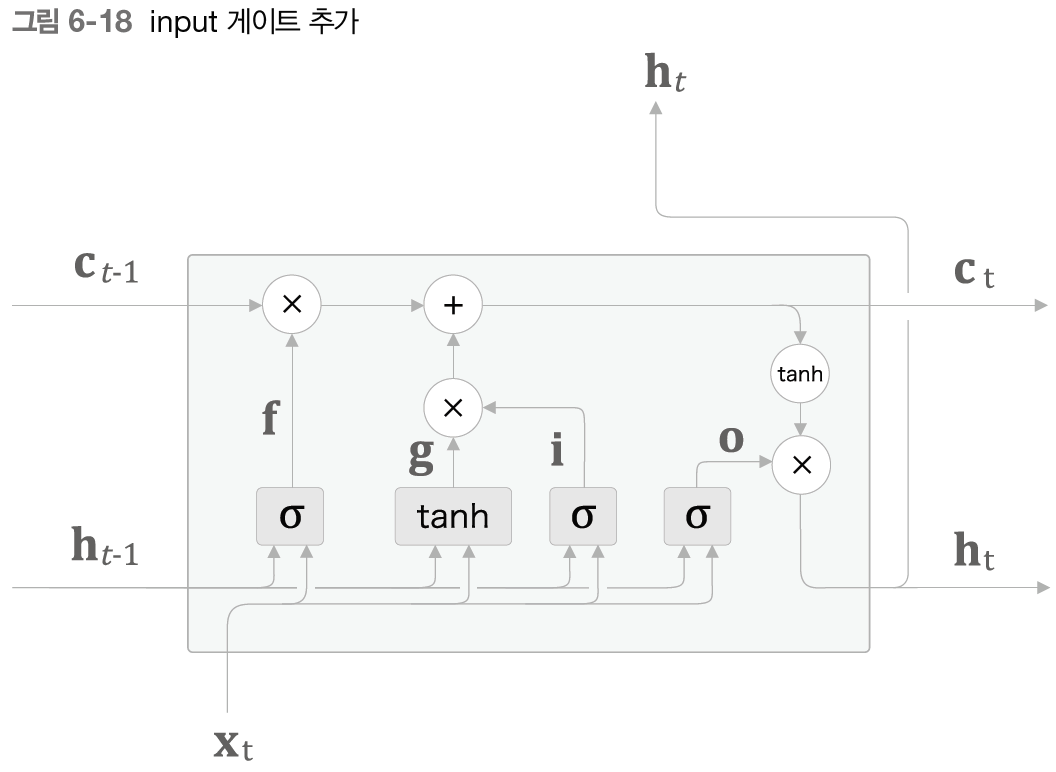

input 게이트는 $g$의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다. 새 정보를 무비판적으로 수용하는 게 아니라, 적절히 취사선택하는 것이 이 게이트의 역할이다. 다른 관점에서 보면, input 게이트에 의해 가중된 정보가 새로 추가되는 셈이다. 이때 수행하는 계산은 다음과 같다.

$$ i = \sigma(x_t W_x^{(i)} + h_{t-1} W_h^{(i)} + b^{(i)}) $$

그런 다음 $i$와 $g$의 원소별 곱 결과를 기억 셀에 추가한다. 이상이 LSTM 안에서 이뤄지는 처리이다.

## **LSTM의 기울기 흐름**

LSTM의 구조에서 기울기 소실을 없애주는 원리를 파악하려면 기억 셀 $c$의 역전파에 주목해야한다. 다음 그림을 보면서 설명한다.

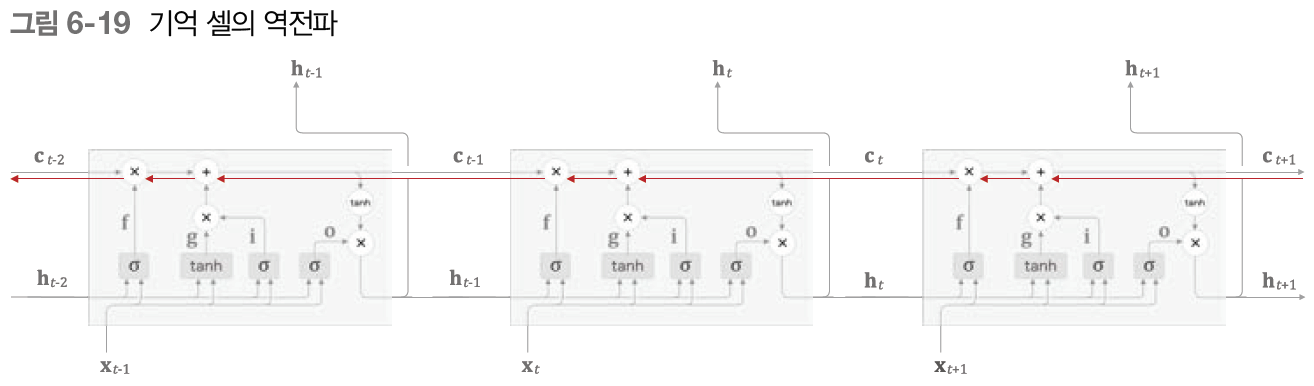


기억 셀의 역전파에서는 덧셈노드와 곱셈노드만을 지나게 된다. 덧셈 노드는 상류에서 전해지는 기울기를 그대로 흘리므로 기울기 변화(감소)는 이뤄지지 않는다.

남은 것은 곱셈노드인데, 이 노드는 RNN의 역전파에서 기울기 소실(또는 폭발)을 일으킨 '행렬 곱'이 아닌 '원소별 곱(아마다르 곱)'을 계산한다. 매 시각 다른 게이트 값을 이용해 원소별 곱을 계산하면 매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않는것이다.

이 곱셈노드의 계산은 forget 게이트가 제어한다(그리고 매 시각 다른 게이트 값을 출력한다). 그리고 forget 게이트가 '잊어야 한다'고 판단한 기억 셀의 원소에 대해서는 그 기울기가 작아지는 것이다. 한편, forget 게이트가 '잊어서는 안된다'고 판단한 원소에 대해서는 그 기울기가 약화되지 않은 채로 과거 방향으로 전해진다. 따라서 기억 셀의 기울기가 (오래 기억해야 할 정보일 경우) 소실 없이 전파되리라 기대할 수 있다.

이상의 논의에서 LSTM의 기억 셀에서는 기울기 손실이 일어나지 않는 이유를 알 수 있었다. 따라서 기억 셀이 장기 의존 관계를 유지(학습)하리라 기대할 수 있다.

# **LSTM 구현**

우선 최초의 한 단계만 처리하는 LSTM 클래스를 구현한 다음, 이어서 $T$ 개의 단계를 한꺼번에 처리하는 Time LSTM 클래스를 구현하겠다.

$$ f = \sigma(x_t W_x^{(f)} + h_{t-1} W_h^{(f)} + b^{(f)}) $$

$$ g = \tanh(x_t W_x^{(g)} + h_{t-1} W_h^{(g)} + b^{(g)}) $$

$$ i = \sigma(x_t W_x^{(i)} + h_{t-1} W_h^{(i)} + b^{(i)}) $$

$$ o = \sigma(x_t W_x^{(o)} + h_{t-1} W_h^{(o)} + b^{(o)}) $$

LSTM에서 수행하는 계산에서 주목할 부분은 네 수식에 포함된 아핀 변환(affine transform)이다. 네 수식에서는 아핀 변환을 개별적으로 수행하지만, 이를 하나의 식으로 정리해 계산할 수 있다. 이를 시각화 하면 다음과 같다.


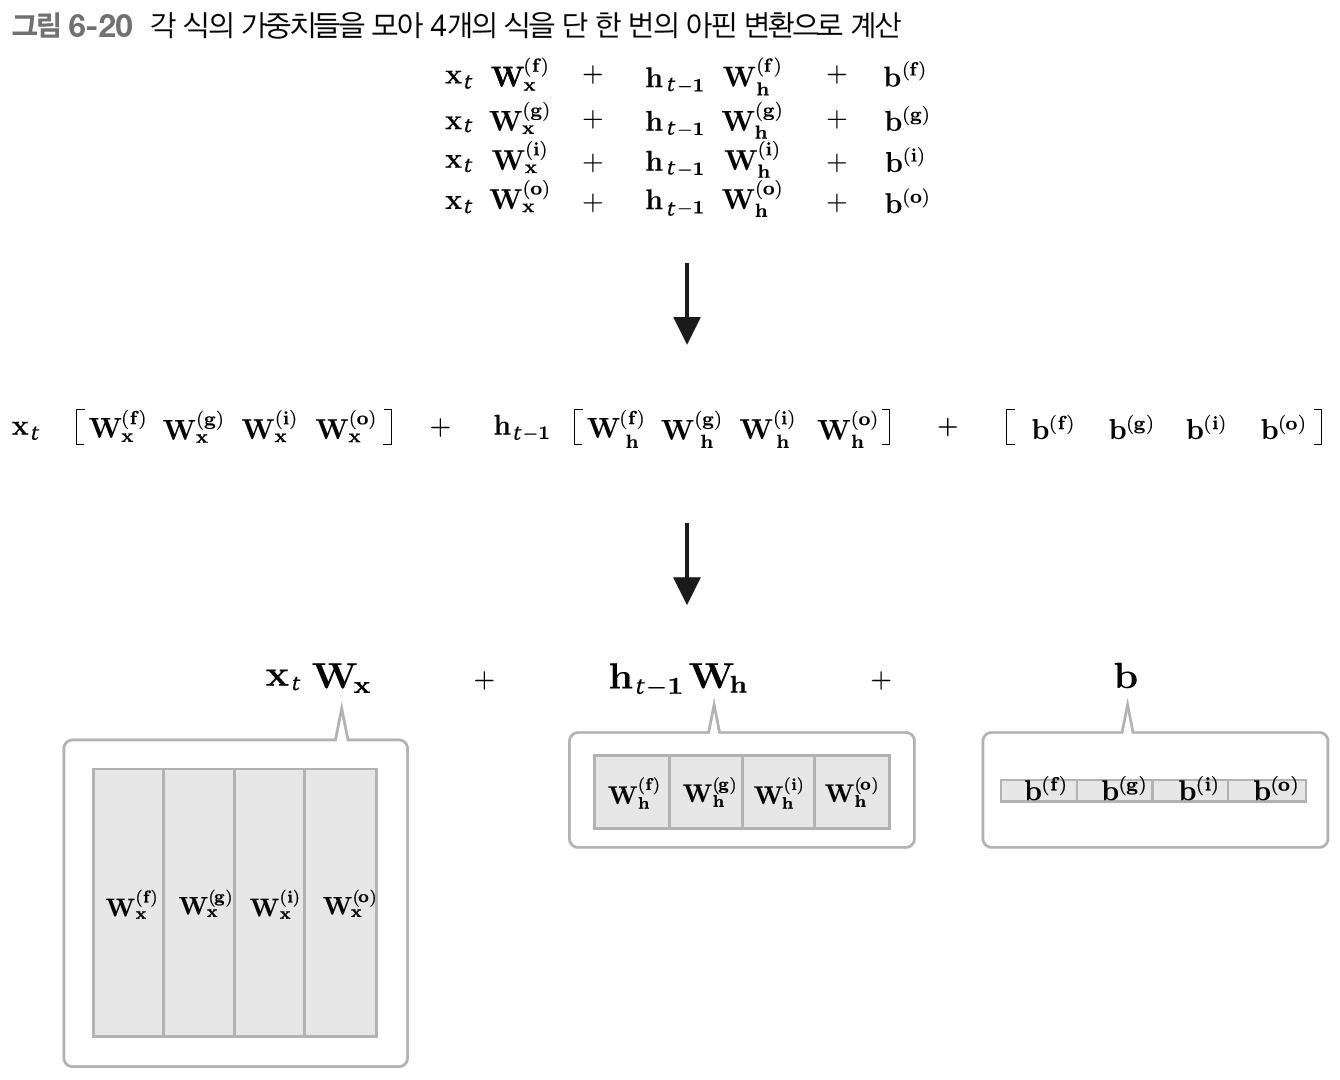

그림에서 보듯 4개의 가중치 (또는 편향)을 하나로 모을 수 있고, 그렇게 하면 원래 개별적으로 총 4번을 수행하던 아핀 변환을 단 1회의 계산으로 끝마친다. 행렬 라이브러리는 '큰 행렬'을 한꺼번에 계산하는 것이 빠르기 때문에 계산이 빨라진다는 뜻이다. 따라서 처음 4개분의 아핀 변환을 한꺼번에 수행하는데 이때, 아핀 변환의 결과(행렬)를 균등하게 네 조각으로 나눠서 꺼내주는 단순한 slice 노드라는 것을 추가한다. 이제, LSTM 클래스를 구현해보자.

In [5]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None       # 순전파 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도의 인스턴스 변수

    # 순전파 구현
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

        # sclice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    # 역전파 구현
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))    # 역전파에서 slice 노드는 순전파와 반대로 4개의 기울기를 결합해야 한다.

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

## **Time LSTM 구현**

Time LSTM은 $T$개분의 시계열 데이터를 한꺼번에 처리하는 계층으로, 다음 그림과 같이 $T$개의 LSTM 계층으로 구성된다.

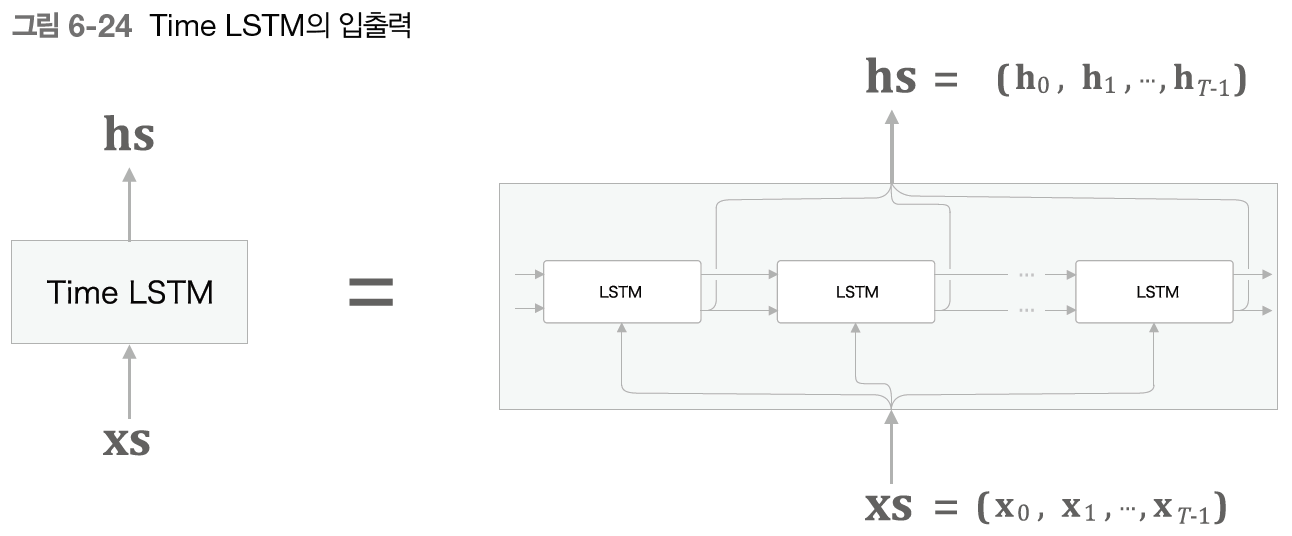

그런데 앞서 말한 것처럼 RNN에서는 학습할 때 Truncated BPTT를 수행했다. Truncated BPTT는 역전파의 연결은 적당한 길이로 끊지만, 순전파의 흐름은 그대로 유지한다. 따라서 은닉 상태와 기억 셀을 인스턴스 변수로 유지하겠다. Time LSTM 계층도 Time RNN 계층과 같은 요령으로 구현하면 된다.

In [6]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

# **LSTM을 사용한 언어 모델**

앞장의 Time RNN 계층이 차치하던 부분이 Time LSTM 계층으로 바뀐 것 말고는 앞 장에서 구현한 언어 모델과 거의 같다. 복습할 겸 다음 그림을 확인하자.

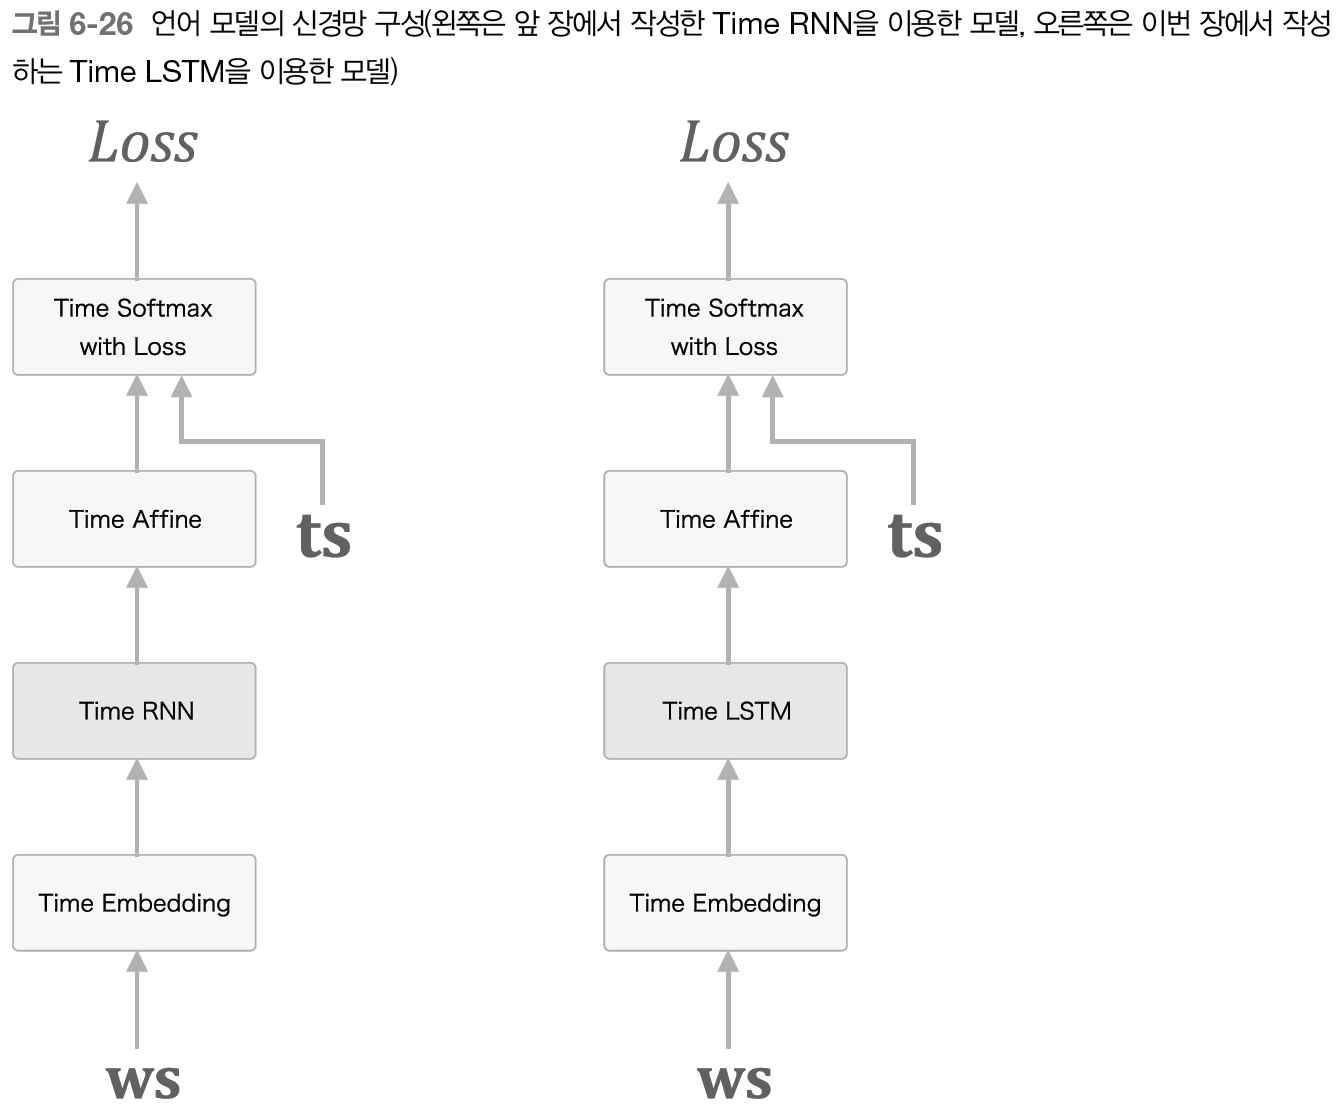

우리는 오른쪽 신경망을 Rnnlm이라는 클래스로 구현한다. LSTM 계층을 사용하는 Rnnlm 클래스의 구현은 다음과 같다.

In [7]:
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝2/deep-learning-from-scratch-2-master'
import sys
sys.path.append(path)

from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

이 신경망을 사용해 PTB 데이터셋을 학습해보자. 학습을 위한 코드는 다음과 같다.

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9998.33
| 에폭 1 |  반복 21 / 1327 | 시간 5[s] | 퍼플렉서티 3031.07
| 에폭 1 |  반복 41 / 1327 | 시간 11[s] | 퍼플렉서티 1228.90
| 에폭 1 |  반복 61 / 1327 | 시간 17[s] | 퍼플렉서티 984.70
| 에폭 1 |  반복 81 / 1327 | 시간 22[s] | 퍼플렉서티 794.15
| 에폭 1 |  반복 101 / 1327 | 시간 28[s] | 퍼플렉서티 678.89
| 에폭 1 |  반복 121 / 1327 | 시간 33[s] | 퍼플렉서티 646.37
| 에폭 1 |  반복 141 / 1327 | 시간 39[s] | 퍼플렉서티 597.54
| 에폭 1 |  반복 161 / 1327 | 시간 44[s] | 퍼플렉서티 589.29
| 에폭 1 |  반복 181 / 1327 | 시간 50[s] | 퍼플렉서티 599.00
| 에폭 1 |  반복 201 / 1327 | 시간 55[s] | 퍼플렉서티 503.33
| 에폭 1 |  반복 221 / 1327 | 시간 61[s] | 퍼플렉서티 500.29
| 에폭 1 |  반복 241 / 1327 | 시간 66[s] | 퍼플렉서티 442.80
| 에폭 1 |  반복 261 / 1327 | 시간 71[s] | 퍼플렉서티 461.79
| 에폭 1 |  반복 281 / 1327 | 시간 77[s] | 퍼플렉서티 445.14
| 에폭 1 |  반복 301 / 1327 | 시간 82[s] | 퍼플렉서티 398.08
| 에폭 1 |  반복 321 / 1327 | 시간 88[s] | 퍼플렉서티 343.34
| 에폭 1 |  반복 341 / 1327 | 시간 93[s] | 퍼플렉서티 404.65
| 에폭 1 |  반복 361 / 1327 | 시간 99[s] | 퍼플렉서티 408.96
| 에폭 1 |  반복 381 / 1327 | 시간 104[s] | 퍼플렉서티 336.64
| 에폭

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

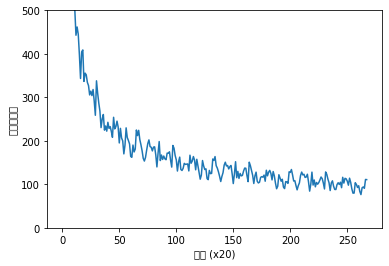

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.8506823639424


In [12]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

학습을 계속하면서 퍼플렉서티 값이 계속 좋아지고 있음을 알 수 있다. 하지만 결과적으로 나온 값(약 137)이라는 값이 실제로 좋은 값인가 물어보면 그다지 좋은 결과는 아니라고 할 수 있다. 2017년 기준 연구에서 PTB 데이터셋의 퍼플렉서티가 60을 밑돌고 있으니 말이다. 우리 모델은 아직 개선할 여지가 많다는 방증이고, 다음 절에서 현재의 RNNLM을 한층 더 개선한다.

# **RNNLM 추가 개선**

## **LSTM 계층 다층화**


RNNLM으로 정확한 모델을 만들고자 한다면 많은 경우 LSTM 계층을 깊게 쌓아 효과를 볼 수 있다. 다음 그림 처럼 말이다.

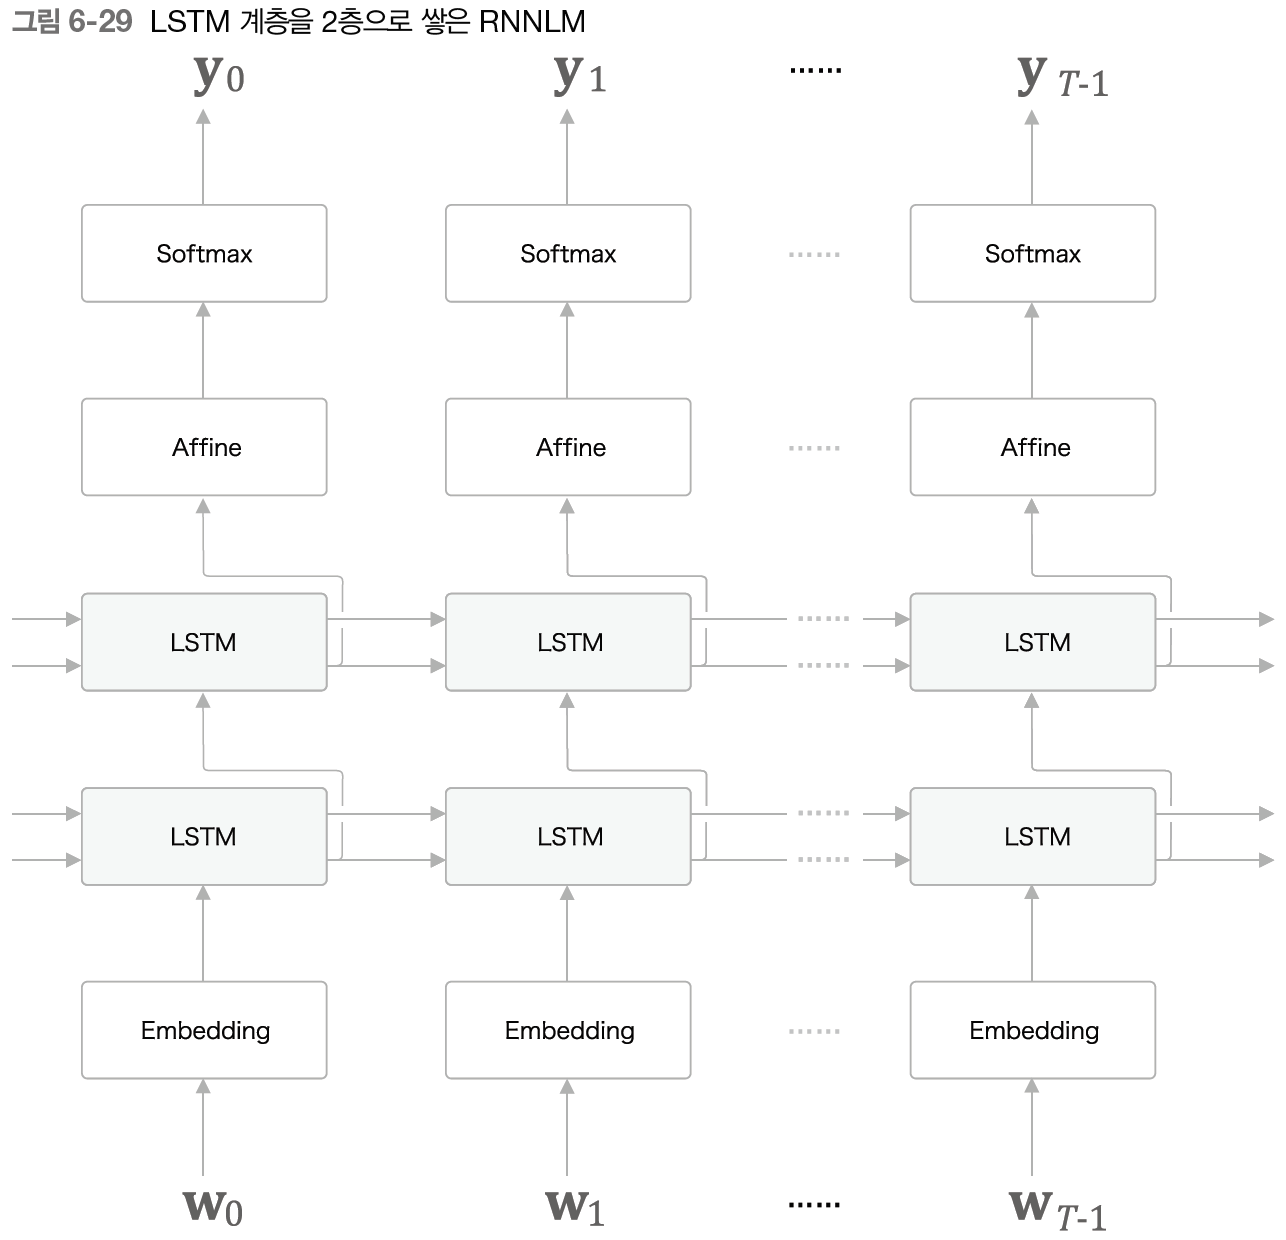

이와 같은 요령으로 LSTM 계층을 몇 층이라도 쌓을 수 있으며, 그 결과 더 복잡한 패턴을 학습할 수 있게 된다. 피드포워드 신경망에서 계층을 쌓는 이야기와 같다.

몇 층이나 쌓아야 하냐의 문제는 하이퍼파라미터에 관한 문제 이므로 처리할 문제의 복잡도나 준비된 학습 데이터의 양에 따라 적절하게 결정해야 한다.

## **드롭아웃에 의한 과적합 억제**

LSTM 계층을 다층화하면 시계열 데이터의 복잡한 의존 관계를 핛브할 수 있을 것이라 기대된다. 즉 표현력이 풍부한 모델을 만들 수 있다. 하지만 이러한 모델은 종종 **과적합(overfitting)**을 일으킨다. 불행하게도 RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킨다. 따라서 RNN의 과적합 대책은 중요하다.

과적합을 억제하는 방법에는 '훈련 데이터의 양 늘리기', '모델의 복잡도 줄이기', 그 외에도 모델의 복잡도에 페널티를 주는 **정규화(normalization)**도 효과적이다. 예컨대 L2 정규화는 가중치가 너무 커지면 페널티를 부과한다.

또, 드롭아웃(dropout)처럼 훈련 시 계층 내의 뉴런 몇 개를 무작위로 무시하고 학습하는 방법도 일종의 정규화 라고 할 수 있다. 이번 절에서는 드롭아웃을 RNN에 적용해본다.

드롭아웃에서의 뉴런에 대한 '무작위한 무시'가  제약이 되어 신경망의 일반화 성능을 개선한다.

RNN을 사용한 모델에서 드롭아웃 계층을 어디에 삽입해야 할까? 첫 번째 후보는 LSTM 계층의 시계열 방향으로 삽입하는 것이다. 하지만 이는 좋은 방법이 아니다.

RNN에서 시계열 방향으로 드롭아웃을 넣어버리면 (학습 시) 시간이 흐름에 따라 정보가 사라질 수 있다. 즉, 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적된다.

드롭아웃 계층을 깊이 방향(상하 방향)으로 삽입하는 것은 어떨까? 다음 그림을 참고하자.

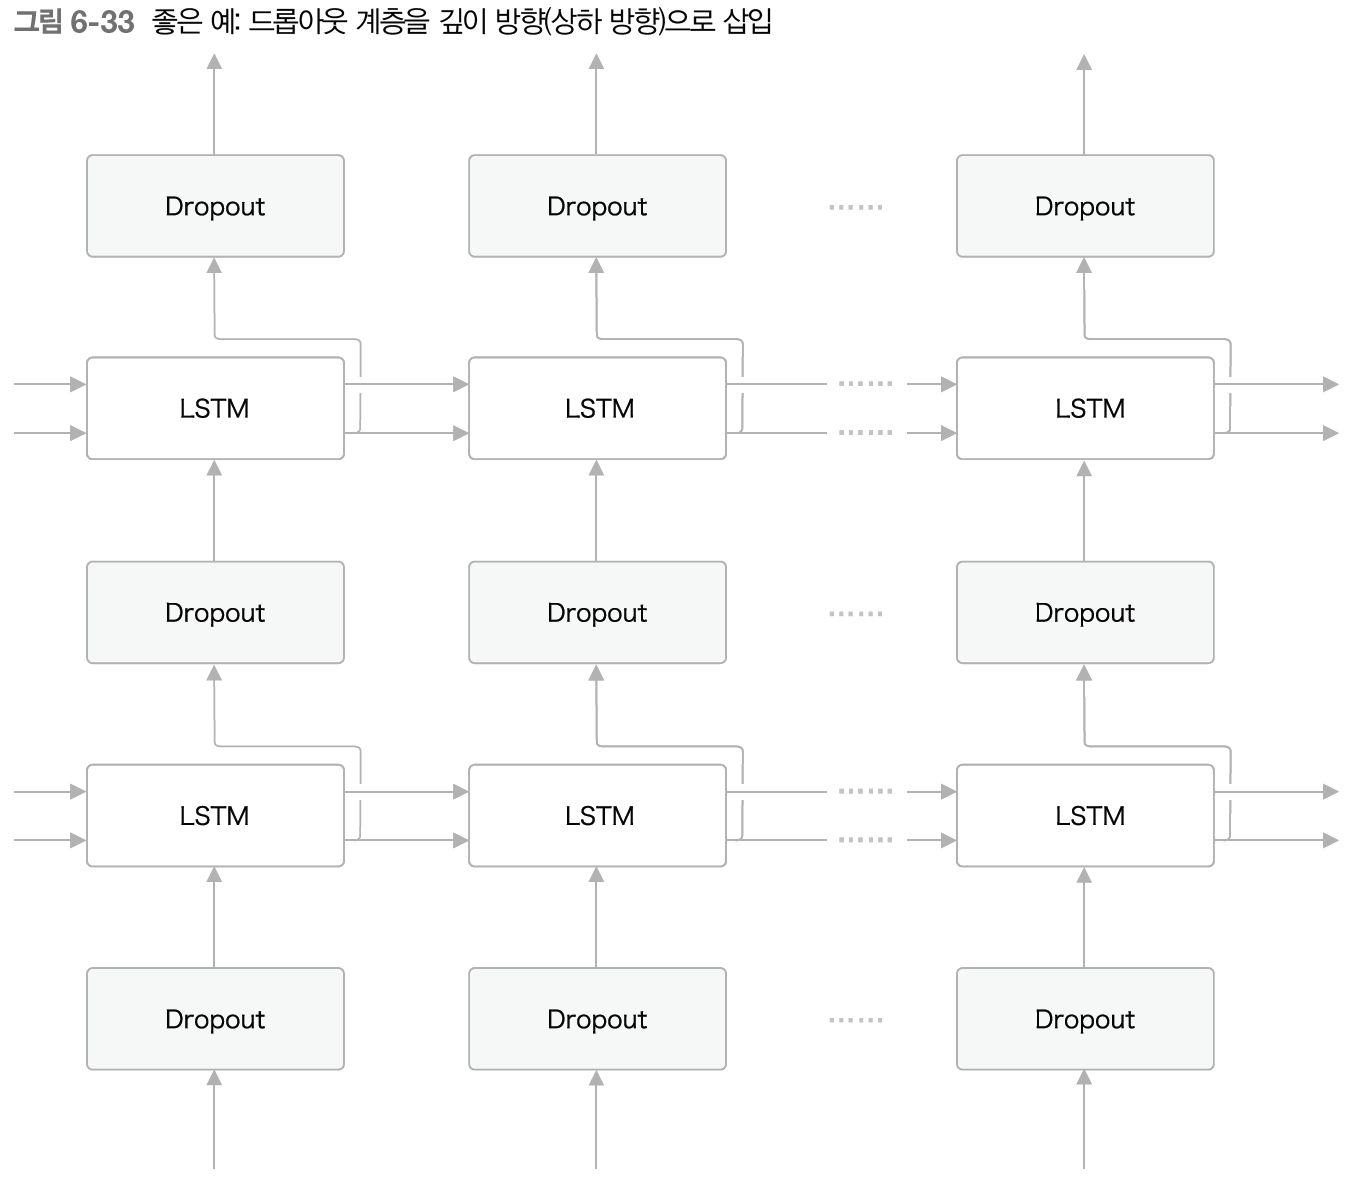

이렇게 구성하면 시간 방향(좌우 방향)으로 아무리 진행해도 정보를 잃지 않는다. 드롭아웃이 시간축과는 독립적으로 깊이 방향에만 영향을 준다.

하지만 **변형 드롭아웃(Variational Dropout)**을 사용하면 시간 방향으로 적용하는 것도 가능하다. 깊이 방향은 물론 시간 방향에도 이용할 수 있어 언어 모델의 정확도를 한층 더 향상시킨다. 그 구조에서 같은 계층에 속한 드롭아웃들은 같은 데이터의 '통과/차단'을 결정하는 이진(binary)형태의 무작위 패턴인 '마스크(mask)'를 공유한다.

같은 계층의 드롭아웃끼리 마스크를 공유함으로써 마스크가 '고정'되므로 정보를 잃게 되는 방법도 '고정'된다. 따라서 일반적인 드롭아웃 때와 달리 정보가 지수적으로 손실되는 사태를 피할 수 있다.

변형 드롭아웃은 일반 드롭아웃보다 결과가 좋다고 알려져있지만, 이책에서는 다루지 않겠다.

## **가중치 공유**

언어 모델을 개선하는 아주 간단한 트릭 중에는 **가중치 공유(weight tying)**이 있다. 직역하면 '가중치를 연결한다'이지만, 실질적으로는 가중치를 공유하는 효과를 준다. 다음 그림을 살펴보자.

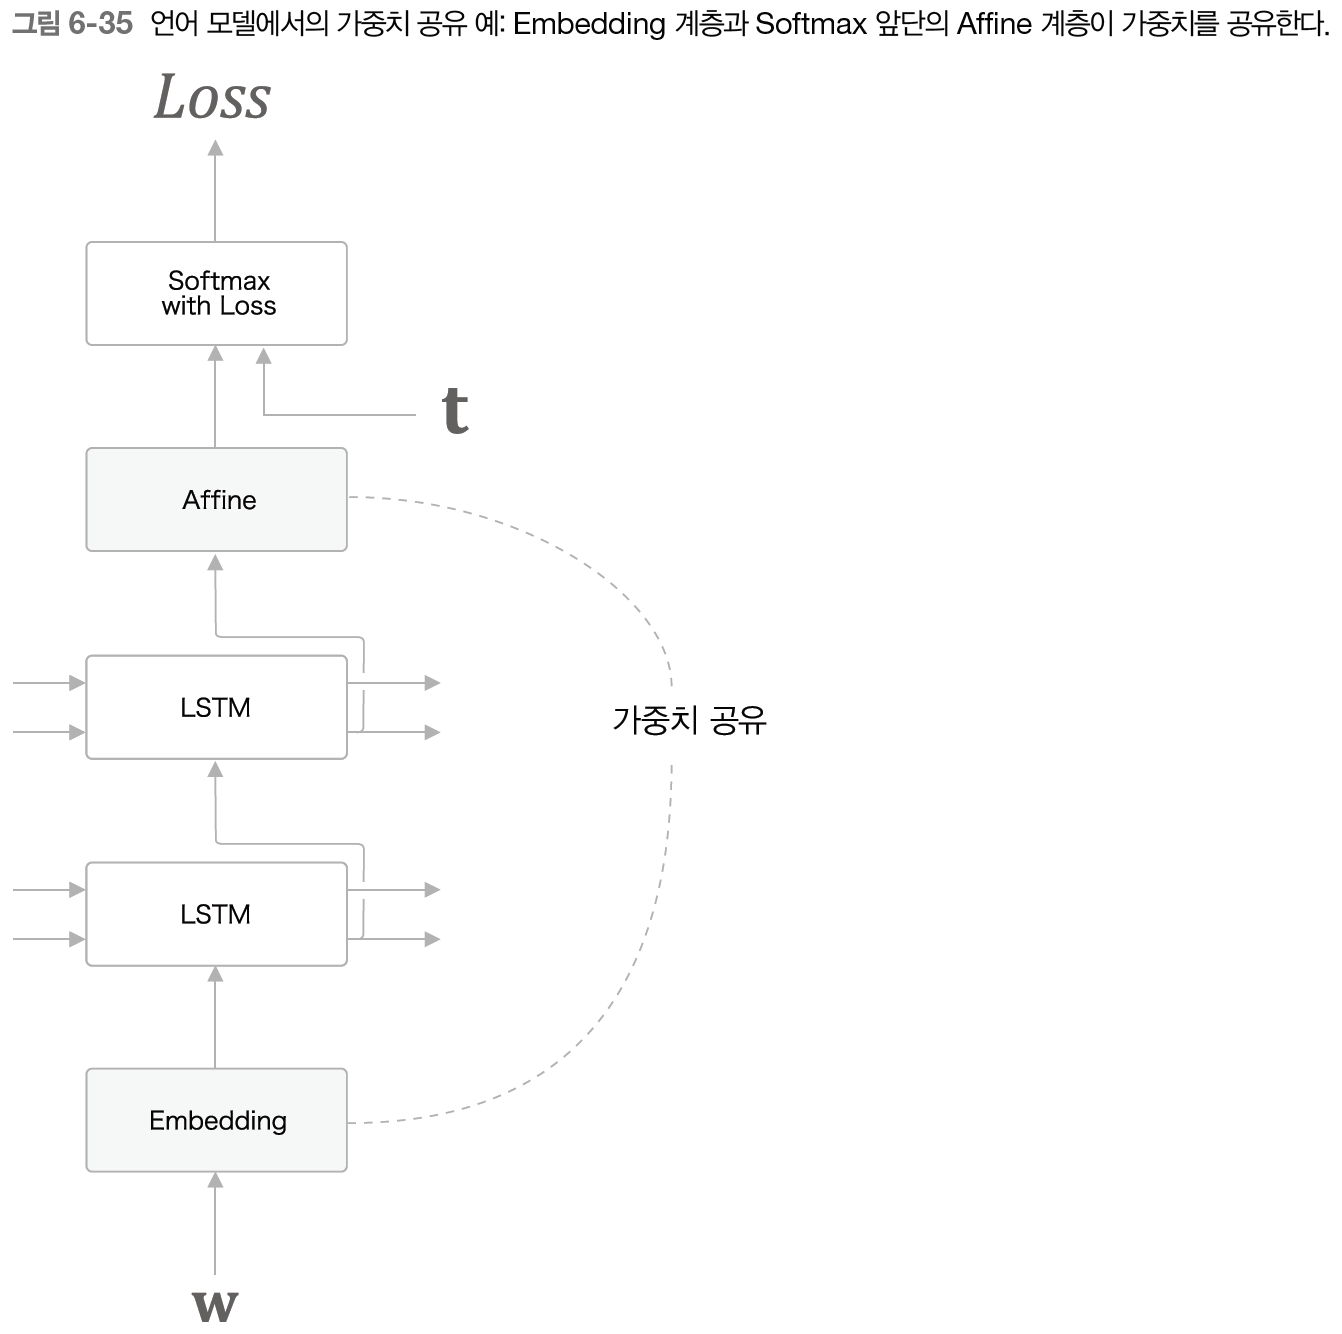

위 그림처럼 Embedding 계층의 가중치와 Affine 계층의 가중치를 연결하는(공유하는) 기법이 가중치 공유이다. 두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상된다.

가중치 공유가 효과가 있는 이유는 가중치를 공유함으로써 학습해야할 매개변수 수를 줄일 수 있고, 그 결과 학습하기가 더 쉬워지며 과적합이 억제되는 혜택으로 이어진다는 것이다.

## **개선된 RNNLM 구현**

* LSTM 계층의 다층화
* 드롭아웃 사용(깊이 방향으로만 적용)
* 가중치 공유(Embedding 계층과 Affine 계층에서 가중치 공유)

이 세가지 개선점을 도입한 BetterRnnlm 클래스를 구현한다.

In [9]:
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.
     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 세가지의 개선!
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

다음은 이 개선된 BetterRnnlm 클래스를 학습시킬 것이다. 하지만 그전에, 매 에폭에서 검증 데이터로 퍼플렉서티를 평가하고, 그 값이 나빠졌을 경우에만 학습률을 낮춘다. 이 기술은 실전에서 자주 쓰이며 더 좋은 결과로 이어지는 경우가 많다.

In [11]:
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

GPU를 사용하더라도 5시간 정도 시간이 걸리므로 결과출력은 생략하자. 결과는 퍼플렉서티락 순조롭게 낮아지고 최종 퍼플렉서티는 75정도로 개선 전 퍼플렉서티 137에 비해 상당히 개선됐다고 할 수 있다.

# **정리**

* **단순한 RNN의 학습에서는 기울기 소실과 기울기 폭발이 문제가 된다.**
* **기울기 폭발에는 기울기 클리핑, 기울기 소실에는 게이트가 추가된 RNN (LSTM과 GRU 등)이 효과적이다.**
* **LSTM에는 input 게이트, forget 게이트, output 게이트 등 3개의 게이트가 있다.**
* **게이트에는 전용 가중치가 있으며, 시그모이드 함수를 사용하여 0.0~1.0 사이의 실수를 출력한다.**
* **언어 모델 개선에는 LSTM 계층 다층화, 드롭아웃, 가중치 공유 등의 기법이 효과적이다.**
* **RNN의 정규화는 중요한 주제이며, 드롭아웃 기반의 다양한 기법이 제안되고 있다.**